In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import networkx as nx
from pyvis import network as net
from math import floor, ceil

In [12]:
from sklearn.datasets import make_circles, make_blobs

data = make_circles(n_samples = 10000, noise = 0.03, random_state = 44, factor = 0.5)
# data = make_blobs(n_samples = 5000, n_features = 5, random_state = 44)

In [13]:
labels = data[1]
data = data[0]

<IPython.core.display.Javascript object>


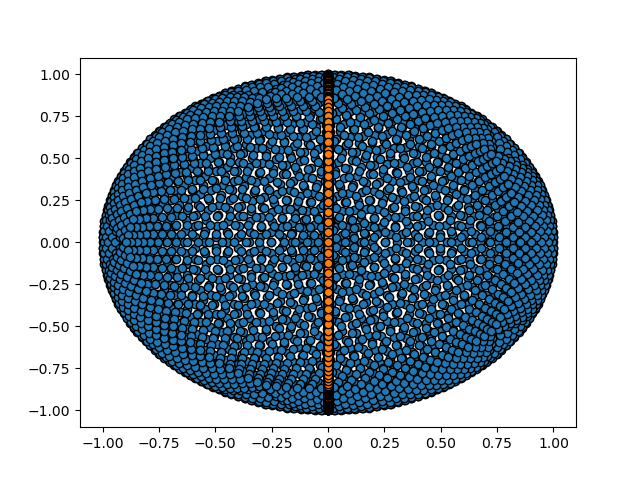

In [105]:
from mpl_toolkits.mplot3d import Axes3D
import random

x = [i[0] for i in data]
y = [i[1] for i in data]

fig = plt.figure()
plt.plot(x, y, 'o', markeredgecolor = 'k', markersize = 6)

# x = [i[0] for i in data]
# y = [i[1] for i in data]
# z = [i[2] for i in data]

# fig = plt.figure()
# ax = Axes3D(fig)
# ax.plot(x, y, z, 'o', markeredgecolor = 'k', markersize = 6)
# plt.show()

In [127]:
# y = [i[1] for i in data]

# plt.plot([0] * len(y), y,'o', markeredgecolor = 'k', markersize = 6)

x = [i[0] for i in data]
y = [i[1] for i in data]

plt.plot(x, y,'o', markeredgecolor = 'k', markersize = 6)

In [156]:
def get_cover(range_, interval_len, overlap):
    assert len(range_) == len(interval_len) == len(overlap), "Dimension mismatch!"
    cover = []
    for i in range(len(range_)):
        range_min = range_[i][0]
        range_max = range_[i][1]
        intervals = []
        upto_low, upto_high = range_min, range_min + interval_len[i]
        while True:
            if upto_high >= range_max:
                intervals.append((upto_low, range_max))
                break

            intervals.append((round(upto_low, 10), round(upto_high, 10)))
            upto_low += (interval_len[i] - overlap[i])
            upto_high += (interval_len[i] - overlap[i])
        
        cover.append(intervals)
    
    return cover

# cover = get_cover(range_ = [(-1.3, 1.3)], interval_len = [0.1], overlap = [0.03])
# cover = get_cover(range_ = [(-2, 13), (-12, 3)], interval_len = [2, 1], overlap = [0.5, 0.3])
# cover = get_cover(range_ = [(-0.1, 0.1)], interval_len = [0.02], overlap = [0.005])
cover = get_cover(range_ = [(-1.1, 1.1)], interval_len = [0.2], overlap = [0.1])
print(cover)

[[(-1.1, -0.9), (-1.0, -0.8), (-0.9, -0.7), (-0.8, -0.6), (-0.7, -0.5), (-0.6, -0.4), (-0.5, -0.3), (-0.4, -0.2), (-0.3, -0.1), (-0.2, -0.0), (-0.1, 0.1), (-0.0, 0.2), (0.1, 0.3), (0.2, 0.4), (0.3, 0.5), (0.4, 0.6), (0.5, 0.7), (0.6, 0.8), (0.7, 0.9), (0.8, 1.0), (0.9, 1.1), (0.9999999999999998, 1.1)]]


In [7]:
def get_clusters(filter_func, cover, data):
    assert len(cover) == len(filter_func), "Dimension mismatch!"
    clusters = []
    
    def _get_clusters(filter_func, cover, data, __rec_num, __low, __high):
        if __rec_num < len(cover):
            for (low, high) in cover[__rec_num]:
                __low[__rec_num], __high[__rec_num] = low, high
                _get_clusters(filter_func, cover, data, __rec_num + 1, __low, __high)
        else:
            to_cluster = []
            for p in data:
                flag = True
                for i in range(len(__low)):
                    flag = flag and (filter_func[i](p) >= __low[i] and filter_func[i](p) <= __high[i])

                if flag:
                    to_cluster.append(p)

            if len(to_cluster):
                to_cluster = np.array(to_cluster)
#                 db = DBSCAN(algorithm = 'auto', eps = 0.05, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
                db = DBSCAN(algorithm = 'auto', eps = 1, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
                labels = np.array(db.labels_)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                for i in range(0, n_clusters):
                    clusters.append(set([tuple(p) for p in to_cluster[labels == i]]))
    
    l = len(filter_func)
    _get_clusters(filter_func, cover, data, __rec_num = 0, __low = [0] * l, __high = [0] * l)
    return clusters

def filter_func_1(p):
    return p[0]

def filter_func_2(p):
    return p[1]

# filter_func = [filter_func_2]
# clusters = get_clusters(filter_func, cover, data)

filter_func = [filter_func_1, filter_func_2]
clusters = get_clusters(filter_func, cover, data)

In [162]:
from win32api import GetSystemMetrics

def create_graph(file_name):
    cluster_sizes = np.array([len(i) for i in clusters])
    max_nodes = max(cluster_sizes)
    min_nodes = min(cluster_sizes)
    g = net.Network(GetSystemMetrics(1), GetSystemMetrics(0), bgcolor="#222222")
    g.add_nodes(nodes = range(0, len(clusters), 1),
                size = [((i - min_nodes + len(clusters)) / (max_nodes - min_nodes)) * 100 for i in cluster_sizes],
                title = ["Contains " + str(len(x)) + " elements" for x in clusters],
                label = [' '] * len(clusters),
                color = ['#%02x%02x%02x' % (255, 255 - int(len(i) / max_nodes * 255), 0) for i in clusters])
    for i in range(0, len(clusters)):
        for j in range(i + 1, len(clusters)):
            if clusters[i].intersection(clusters[j]):
                g.add_edge(i, j, color = '#ffdd00')

    g.set_options("""
    var options = {
    "nodes": {
        "shadow": {
        "enabled": true
        }
    },
    "edges": {
        "color": {
        "inherit": true
        },
        "smooth": true
    },
    "physics": {
        "barnesHut": {
        "centralGravity": 0,
        "springLength": 1,
        "springConstant": 0.01,
        "avoidOverlap": 0.5
        },
        "minVelocity": 0.75
    }
    }
    """)
    g.show(file_name)
    return g

graph = create_graph("sphere20.html")

<IPython.core.display.Javascript object>


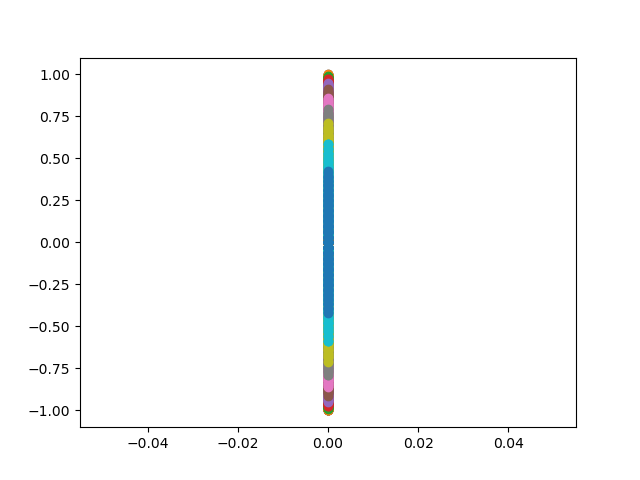

In [161]:
clusters_list = [list(cluster) for cluster in clusters]
X = [[0 for p in cluster] for cluster in clusters_list]
Y = [[p[1] for p in cluster] for cluster in clusters_list]
labels = range(1, len(X) + 1)

fig = plt.figure()
ax = fig.add_subplot(111)

colormap = plt.cm.gist_ncar
colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
for t,j1 in enumerate(ax.collections):
    j1.set_color(colorst[t])

for x,y,lab in zip(X,Y,labels):
        ax.scatter(x,y,label=lab)

# clusters_list = [list(cluster) for cluster in clusters]
# X = [[p[0] for p in cluster] for cluster in clusters_list]
# Y = [[p[1] for p in cluster] for cluster in clusters_list]
# labels = range(1, len(X) + 1)

# fig = plt.figure()
# ax = fig.add_subplot(111)

# colormap = plt.cm.gist_ncar
# colorst = [colormap(i) for i in np.linspace(0, 0.9,len(ax.collections))]       
# for t,j1 in enumerate(ax.collections):
#     j1.set_color(colorst[t])

# for x,y,lab in zip(X,Y,labels):
#         ax.scatter(x,y,label=lab)

In [160]:
def get_clusters(filter_func, cover, data):
    clusters = []
    
    def _get_clusters(filter_func, cover, data, __rec_num, __low, __high):
        if __rec_num < len(cover):
            for (low, high) in cover[__rec_num]:
                __low[__rec_num], __high[__rec_num] = low, high
                _get_clusters(filter_func, cover, data, __rec_num + 1, __low, __high)
        else:
            to_cluster = []
            for p in data:
                flag = True
                interval = []
                for i in range(l):
                    interval.append((__low[i], __high[i]))
                    
                flag = filter_func(point = p, interval = interval)
                if flag:
                    to_cluster.append(p)

            if len(to_cluster):
                to_cluster = np.array(to_cluster)
#                 db = DBSCAN(algorithm = 'auto', eps = 0.05, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
#                 db = DBSCAN(algorithm = 'auto', eps = 1, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
#                 db = DBSCAN(algorithm = 'auto', eps = 0.0065, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
                db = DBSCAN(algorithm = 'auto', eps = 0.3, leaf_size = 30, metric = 'euclidean', min_samples = 3, p = None).fit(to_cluster)
                labels = np.array(db.labels_)
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                for i in range(0, n_clusters):
                    clusters.append(set([tuple(p) for p in to_cluster[labels == i]]))
    
    l = len(cover)
    _get_clusters(filter_func, cover, data, __rec_num = 0, __low = [0] * l, __high = [0] * l)
    return clusters

def filter_func(p, interval):
    flag = True
    for i in range(len(interval)):
        flag = flag and (p[i] >= interval[i][0] and p[i] <= interval[i][1])
    
    return flag

clusters = get_clusters(filter_func, cover, data)

In [3]:
def get_data(file_name):
    data = []
    file = open(file_name, "r")
    lines = file.readlines()
    end = int(lines[0][:-1].split(' ')[0]) + 1
    for i in range(1, end):
        point = list(map(float, lines[i][:-1].split(' ')))
        data.append(point)
    
    return np.array(data)

data = get_data("data/horse.gts")

In [4]:
data.shape

(48485, 3)

<IPython.core.display.Javascript object>


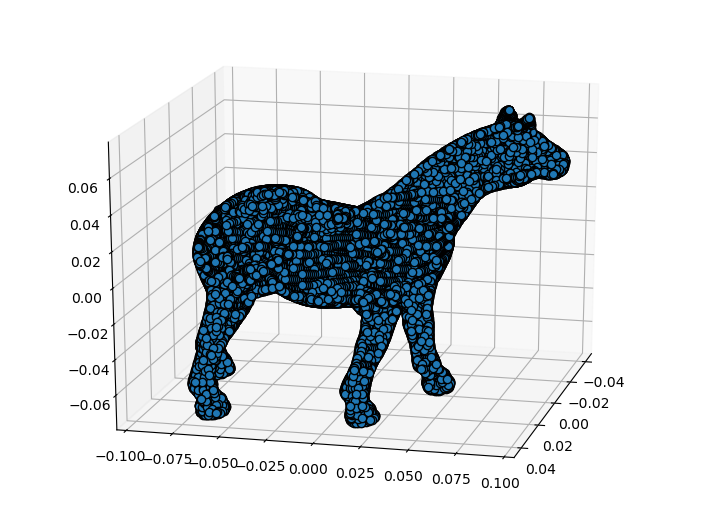

In [5]:
%matplotlib notebook

from mpl_toolkits.mplot3d import Axes3D
import random

x = [i[0] for i in data]
y = [i[1] for i in data]
z = [i[2] for i in data]

fig = plt.figure()
ax = Axes3D(fig)
ax.plot(x, y, z, 'o', markeredgecolor = 'k', markersize = 6)
plt.show()

In [6]:
data.shape

(48485, 3)

In [15]:
def get_distances(p):
    distances = dict()
    for x in data:
        s = 0
        for y in data:
            s += (np.linalg.norm(x - y) ** p)
    
        distances[tuple(x)] = (s / len(data)) ** (1 / p)
    
    return distances

distances = get_distances(1)

KeyboardInterrupt: 

In [ ]:
def eccentricity_1(point, interval, distances = distances):
    return distances[tuple(point)] >= interval[0] and distances[tuple(point)] <= interval[1]

In [ ]:
print(min(distances.values), max(distances.values))